# Fleet engine health analytics

### Load data

In [45]:
import pandas as pd

In [46]:
# Column names based on NASA documentation
columns = [
    "engine_id", "cycle",
    "op_setting_1", "op_setting_2", "op_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]

In [47]:
# Load training data
train_df = pd.read_csv(
    "CMAPSSData/train_FD001.txt",
    sep=r"\s+",
    header=None,
    names=columns
)


In [48]:
# Remove empty columns (due to extra spaces)
train_df = train_df.dropna(axis=1)

train_df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Sanity Check

In [49]:
# Shape of the data
train_df.shape


(20631, 26)

In [50]:
# Number of engines
train_df["engine_id"].nunique()


100

In [51]:
# Cycles per engine
train_df.groupby("engine_id")["cycle"].max().describe()


count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: cycle, dtype: float64

In [52]:
import matplotlib.pyplot as plt


In [53]:
engine_example = train_df[train_df["engine_id"] == 1]

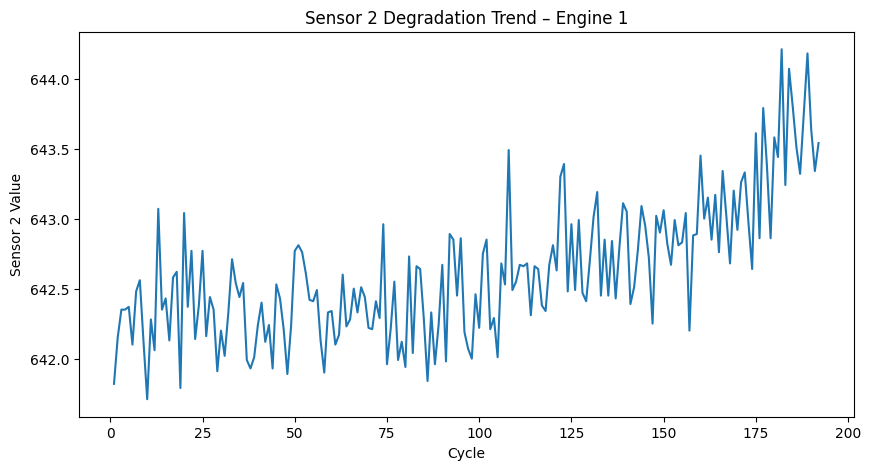

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(engine_example["cycle"], engine_example["sensor_2"])
plt.xlabel("Cycle")
plt.ylabel("Sensor 2 Value")
plt.title("Sensor 2 Degradation Trend – Engine 1")
plt.show()

#### What the graph shows

- X-axis: Operating cycles

- Y-axis: Raw value of Sensor 2

- Each point represents a sensor reading at a given cycle for Engine 1.

#### Explanation

- The sensor values exhibit high short-term variability (noise) but show a clear upward trend over time.

- This gradual increase suggests progressive degradation behavior, where the sensor drifts away from its baseline as the engine ages.

- Individual spikes are expected due to operational variability, but the long-term trend is the key signal of health deterioration.

#### Why it matters

- Demonstrates that raw sensor data alone is noisy, motivating the need for smoothing and feature engineering.

In [55]:
sensor_cols = [col for col in train_df.columns if col.startswith("sensor_")]

sensor_variance = train_df[sensor_cols].var().sort_values(ascending=False)
sensor_variance

sensor_9     4.876536e+02
sensor_14    3.639005e+02
sensor_4     8.101089e+01
sensor_3     3.759099e+01
sensor_17    2.398667e+00
sensor_7     7.833883e-01
sensor_12    5.439850e-01
sensor_2     2.500533e-01
sensor_11    7.133568e-02
sensor_20    3.266927e-02
sensor_21    1.171825e-02
sensor_13    5.172330e-03
sensor_8     5.038938e-03
sensor_15    1.406628e-03
sensor_6     1.929279e-06
sensor_5     3.155597e-30
sensor_16    1.926023e-34
sensor_10    0.000000e+00
sensor_18    0.000000e+00
sensor_19    0.000000e+00
sensor_1     0.000000e+00
dtype: float64

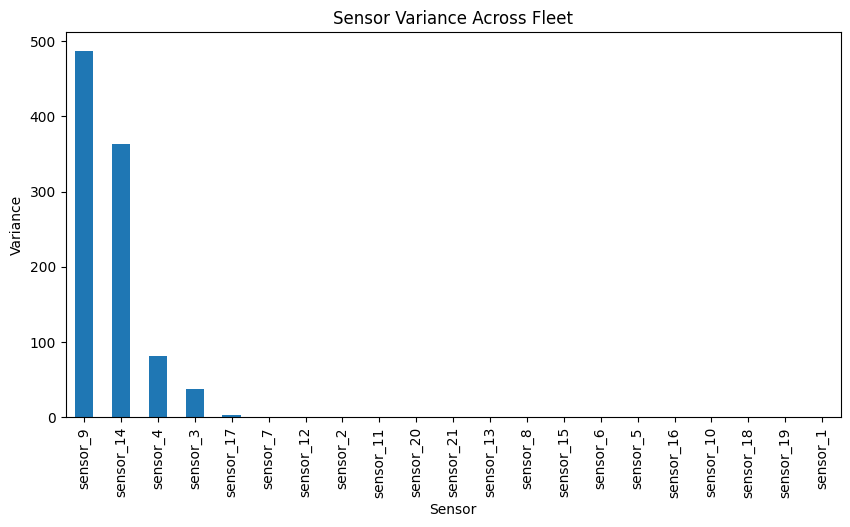

In [56]:
plt.figure(figsize=(10, 5))
sensor_variance.plot(kind="bar")
plt.title("Sensor Variance Across Fleet")
plt.ylabel("Variance")
plt.xlabel("Sensor")
plt.show()


##### What the graph shows

- X-axis: Sensor IDs

- Y-axis: Variance across all engines and cycles

##### Explanation

- Sensors such as sensor_9, sensor_14, sensor_4, and sensor_3 show significantly higher variance.

- Several sensors exhibit near-zero variance, meaning they change very little across time and engines.

##### Why it matters

- High-variance sensors carry informative degradation signals.

- Low-variance sensors provide minimal predictive value and were excluded to reduce noise and dimensionality.

- This step ensures data-driven feature selection, not arbitrary choices.

In [57]:
sensor_variance[sensor_variance < 1e-5]

sensor_6     1.929279e-06
sensor_5     3.155597e-30
sensor_16    1.926023e-34
sensor_10    0.000000e+00
sensor_18    0.000000e+00
sensor_19    0.000000e+00
sensor_1     0.000000e+00
dtype: float64

In [58]:
useful_sensors = sensor_variance[sensor_variance >= 1e-5].index.tolist()

clean_df = train_df[
    ["engine_id", "cycle"] +
    ["op_setting_1", "op_setting_2", "op_setting_3"] +
    useful_sensors
]

clean_df.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_9,sensor_14,sensor_4,sensor_3,sensor_17,sensor_7,sensor_12,sensor_2,sensor_11,sensor_20,sensor_21,sensor_13,sensor_8,sensor_15
0,1,1,-0.0007,-0.0004,100.0,9046.19,8138.62,1400.60,1589.70,392,554.36,521.66,641.82,47.47,39.06,23.4190,2388.02,2388.06,8.4195
1,1,2,0.0019,-0.0003,100.0,9044.07,8131.49,1403.14,1591.82,392,553.75,522.28,642.15,47.49,39.00,23.4236,2388.07,2388.04,8.4318
2,1,3,-0.0043,0.0003,100.0,9052.94,8133.23,1404.20,1587.99,390,554.26,522.42,642.35,47.27,38.95,23.3442,2388.03,2388.08,8.4178
3,1,4,0.0007,0.0000,100.0,9049.48,8133.83,1401.87,1582.79,392,554.45,522.86,642.35,47.13,38.88,23.3739,2388.08,2388.11,8.3682
4,1,5,-0.0019,-0.0002,100.0,9055.15,8133.80,1406.22,1582.85,393,554.00,522.19,642.37,47.28,38.90,23.4044,2388.04,2388.06,8.4294


In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

normalized_sensors = scaler.fit_transform(clean_df[useful_sensors])

normalized_df = clean_df.copy()
normalized_df[useful_sensors] = normalized_sensors

normalized_df.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_9,sensor_14,sensor_4,sensor_3,sensor_17,sensor_7,sensor_12,sensor_2,sensor_11,sensor_20,sensor_21,sensor_13,sensor_8,sensor_15
0,1,1,-0.0007,-0.0004,100.0,-0.862813,-0.269071,-0.925936,-0.134255,-0.781710,1.121141,0.334262,-1.721725,-0.266467,1.348493,1.194427,-1.058890,-0.516338,-0.603816
1,1,2,0.0019,-0.0003,100.0,-0.958818,-0.642845,-0.643726,0.211528,-0.781710,0.431930,1.174899,-1.061780,-0.191583,1.016528,1.236922,-0.363646,-0.798093,-0.275852
2,1,3,-0.0043,0.0003,100.0,-0.557139,-0.551629,-0.525953,-0.413166,-2.073094,1.008155,1.364721,-0.661813,-1.015303,0.739891,0.503423,-0.919841,-0.234584,-0.649144
3,1,4,0.0007,0.0000,100.0,-0.713826,-0.520176,-0.784831,-1.261314,-0.781710,1.222827,1.961302,-0.661813,-1.539489,0.352598,0.777792,-0.224597,0.188048,-1.971665
4,1,5,-0.0019,-0.0002,100.0,-0.457059,-0.521748,-0.301518,-1.251528,-0.136018,0.714393,1.052871,-0.621816,-0.977861,0.463253,1.059552,-0.780793,-0.516338,-0.339845


In [60]:
normalized_df[useful_sensors].describe().loc[["mean", "std"]]

,sensor_9,sensor_14,sensor_4,sensor_3,sensor_17,sensor_7,sensor_12,sensor_2,sensor_11,sensor_20,sensor_21,sensor_13,sensor_8,sensor_15
mean,-4.185765e-14,3.061075e-15,9.285169e-16,-4.959437e-14,1.666922e-14,-3.161641e-14,-1.199702e-13,6.410348e-14,-2.937089e-15,4.156146e-14,2.402296e-14,3.493855e-13,1.008249e-12,-3.244023e-14
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00


The normalized sensor data exhibit near-zero mean and unit standard deviation across all selected sensors, confirming successful z-score standardization. Minor numerical deviations are attributable to floating-point precision and do not impact analytical validity.

In [61]:
# Rolling mean per engine
window = 20

rolling_df = normalized_df.copy()

for sensor in useful_sensors:
    rolling_df[f"{sensor}_roll_mean"] = (
        rolling_df
        .groupby("engine_id")[sensor]
        .rolling(window=window, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

rolling_df.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_9,sensor_14,sensor_4,sensor_3,sensor_17,...,sensor_17_roll_mean,sensor_7_roll_mean,sensor_12_roll_mean,sensor_2_roll_mean,sensor_11_roll_mean,sensor_20_roll_mean,sensor_21_roll_mean,sensor_13_roll_mean,sensor_8_roll_mean,sensor_15_roll_mean
0,1,1,-0.0007,-0.0004,100.0,-0.862813,-0.269071,-0.925936,-0.134255,-0.781710,...,-0.781710,1.121141,0.334262,-1.721725,-0.266467,1.348493,1.194427,-1.058890,-0.516338,-0.603816
1,1,2,0.0019,-0.0003,100.0,-0.958818,-0.642845,-0.643726,0.211528,-0.781710,...,-0.781710,0.776535,0.754581,-1.391753,-0.229025,1.182510,1.215675,-0.711268,-0.657216,-0.439834
2,1,3,-0.0043,0.0003,100.0,-0.557139,-0.551629,-0.525953,-0.413166,-2.073094,...,-1.212171,0.853742,0.957961,-1.148439,-0.491118,1.034970,0.978257,-0.780793,-0.516338,-0.509604
3,1,4,0.0007,0.0000,100.0,-0.713826,-0.520176,-0.784831,-1.261314,-0.781710,...,-1.104556,0.946013,1.208796,-1.026783,-0.753210,0.864377,0.928141,-0.641744,-0.340242,-0.875119
4,1,5,-0.0019,-0.0002,100.0,-0.457059,-0.521748,-0.301518,-1.251528,-0.136018,...,-0.910848,0.899689,1.177611,-0.945789,-0.798141,0.784153,0.954423,-0.669553,-0.375461,-0.768064


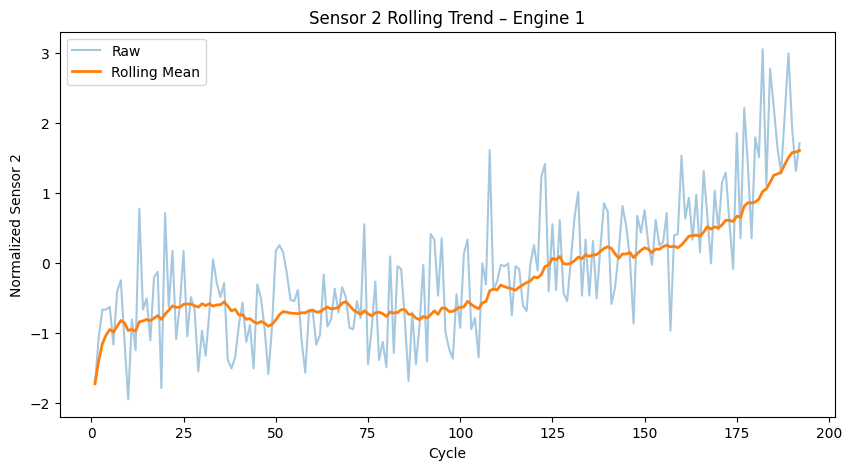

In [62]:
engine_example = rolling_df[rolling_df["engine_id"] == 1]

plt.figure(figsize=(10, 5))
plt.plot(engine_example["cycle"], engine_example["sensor_2"], alpha=0.4, label="Raw")
plt.plot(engine_example["cycle"], engine_example["sensor_2_roll_mean"], linewidth=2, label="Rolling Mean")
plt.legend()
plt.xlabel("Cycle")
plt.ylabel("Normalized Sensor 2")
plt.title("Sensor 2 Rolling Trend – Engine 1")
plt.show()


##### What the graph shows

- Light line: Raw normalized Sensor 2

- Bold line: Rolling mean (window = 20 cycles)

##### Explanation

- The rolling mean smooths out short-term fluctuations while preserving the long-term trend.

- A clear monotonic increase emerges in the rolling curve, making degradation patterns much more interpretable.

- This confirms that Sensor 2 consistently degrades over time.

##### Why it matters

- Rolling features improve signal-to-noise ratio, which is critical for health monitoring and prognostics.

- This mirrors real-world condition monitoring pipelines used in industry.

In [65]:
# Select rolling features only

roll_cols = [col for col in rolling_df.columns if col.endswith("_roll_mean")]
rolling_df["health_score"] = rolling_df[roll_cols].mean(axis=1)


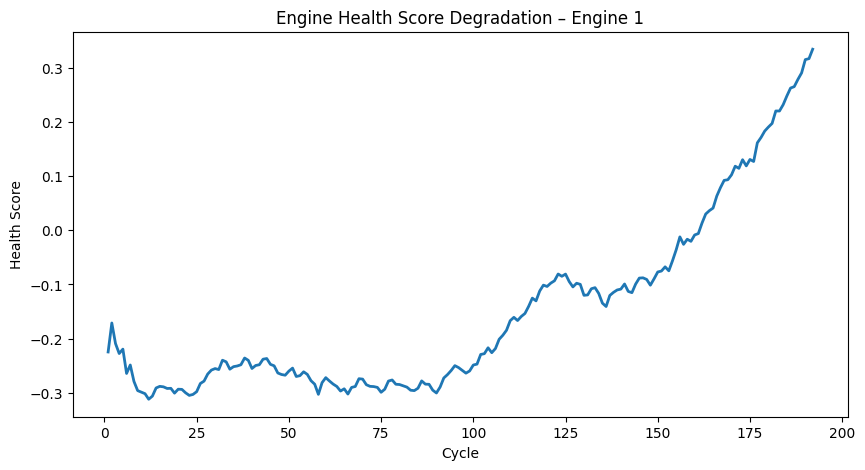

In [67]:
engine_example = rolling_df[rolling_df["engine_id"] == 1]

plt.figure(figsize=(10, 5))
plt.plot(engine_example["cycle"], engine_example["health_score"], linewidth=2)
plt.xlabel("Cycle")
plt.ylabel("Health Score")
plt.title("Engine Health Score Degradation – Engine 1")
plt.show()


#### What the graph shows

- Composite score calculated as the mean of rolling sensor features.

#### Explanation

- The score increases over time because some degrading sensors trend upward while others trend downward.

- While this captures overall degradation magnitude, the direction is not intuitive (higher ≠ healthier).

#### Why it matters

- Highlights an important modeling insight: directionality matters for interpretability.

In [68]:
# Convert to a Degradation Score

rolling_df["degradation_score"] = rolling_df[roll_cols].mean(axis=1)
rolling_df["health_score"] = -rolling_df["degradation_score"]


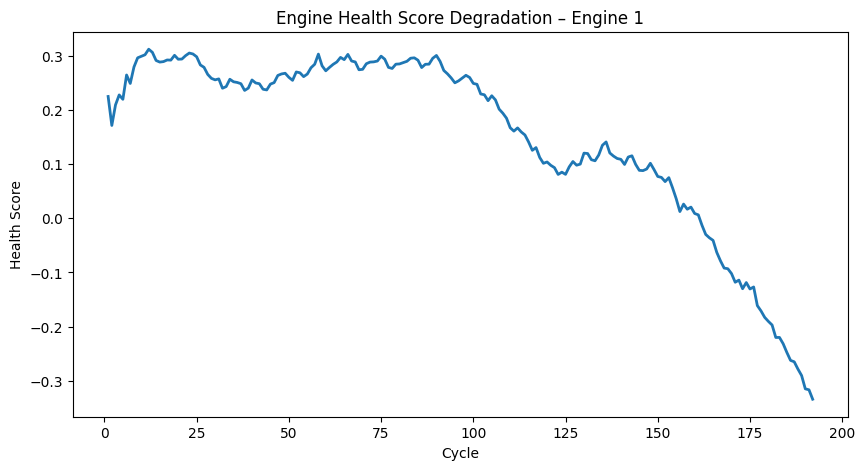

In [69]:
engine_example = rolling_df[rolling_df["engine_id"] == 1]

plt.figure(figsize=(10, 5))
plt.plot(engine_example["cycle"], engine_example["health_score"], linewidth=2)
plt.xlabel("Cycle")
plt.ylabel("Health Score")
plt.title("Engine Health Score Degradation – Engine 1")
plt.show()


#### What the graph shows

- Health score redefined so that higher values = healthier engine.

#### Explanation

- The health score starts high during early life and steadily declines as cycles increase.

- The sharp drop near later cycles indicates accelerated degradation approaching failure.

#### Why it matters

- Produces a human-interpretable health indicator, aligned with how maintenance engineers reason about engine condition.

In [70]:
# Final Health Score per Engine

final_health = (
    rolling_df
    .groupby("engine_id")
    .apply(lambda x: x.loc[x["cycle"].idxmax(), "health_score"])
    .reset_index(name="final_health_score")
)

final_health.head()


/var/folders/wj/zqspx8r57nn98fzn3y89drcw0000gn/T/ipykernel_49945/1091458120.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rolling_df


,engine_id,final_health_score
0,1,-0.333757
1,2,-0.603487
2,3,-0.945312
3,4,-1.032630
4,5,-0.871959


In [71]:
final_health["health_rank"] = final_health["final_health_score"].rank(ascending=True)

final_health.sort_values("health_rank").head(10)


,engine_id,final_health_score,health_rank
50,51,-1.228866,1.0
8,9,-1.164499,2.0
47,48,-1.160785,3.0
17,18,-1.125756,4.0
81,82,-1.099645,5.0
54,55,-1.059271,6.0
96,97,-1.039271,7.0
3,4,-1.032630,8.0
16,17,-0.968131,9.0
2,3,-0.945312,10.0


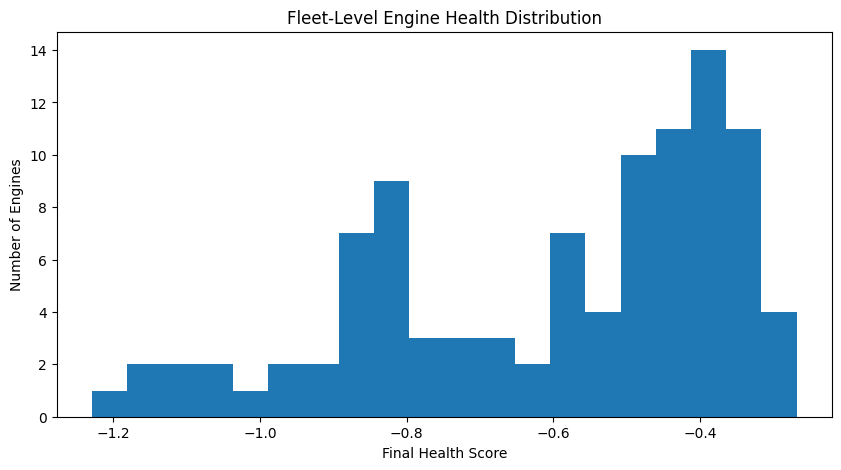

In [72]:
plt.figure(figsize=(10, 5))
plt.hist(final_health["final_health_score"], bins=20)
plt.xlabel("Final Health Score")
plt.ylabel("Number of Engines")
plt.title("Fleet-Level Engine Health Distribution")
plt.show()

#### What the graph shows

- Histogram of final health scores for all engines at end-of-life.

#### Explanation

- The distribution shows significant variability across the fleet.

- Some engines degrade more aggressively, while others maintain relatively higher health until failure.

#### Why it matters

- Demonstrates fleet-level heterogeneity, a key challenge in real-world aviation analytics.

- Enables prioritization of engines for inspection, overhaul, or early intervention.

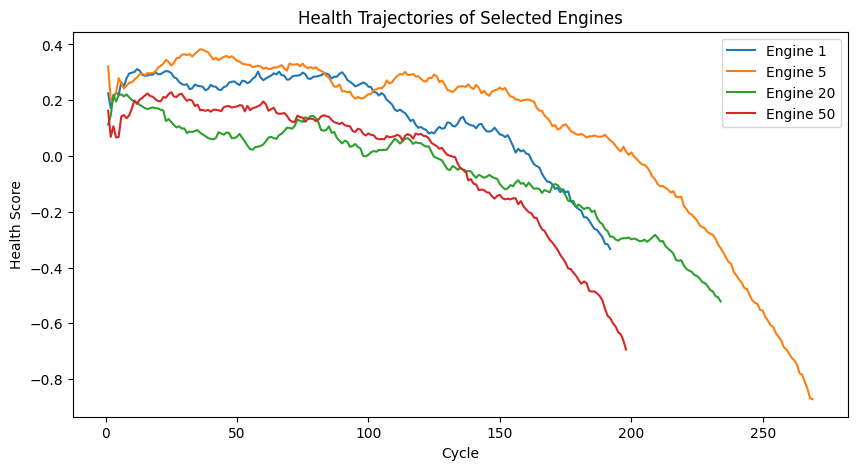

In [74]:
sample_engines = [1, 5, 20, 50]

plt.figure(figsize=(10, 5))
for eng in sample_engines:
    df_e = rolling_df[rolling_df["engine_id"] == eng]
    plt.plot(df_e["cycle"], df_e["health_score"], label=f"Engine {eng}")

plt.xlabel("Cycle")
plt.ylabel("Health Score")
plt.title("Health Trajectories of Selected Engines")
plt.legend()
plt.show()


#### What the graph shows

- Health score vs. cycle for multiple engines (1, 5, 20, 50).

#### Explanation

- Each engine follows a unique degradation trajectory.

- Some engines degrade gradually, while others experience faster or nonlinear decline.

- Confirms that a single global threshold is insufficient for maintenance decisions.